In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
# from src.steinbrinker.BPDN import BPDN
import timeit
import mlflow
import sys

PROJECT_PATH = 'C:\\Users\\galiger.gergo\\Desktop\\ecg-denoising\\workspace'
PROJECT_SRC_PATH = os.path.join(PROJECT_PATH, 'src\\refactored')

sys.path.append(PROJECT_SRC_PATH)

from src.trainers.FISTANetTrainer import FISTANetTrainer
from src.utils.loader import DataSplit


In [2]:
DATA_DIR = './data'
DATA_FILE_GEN = 'generated/BW_master_10000_2024-04-07-12-43-32.pkl'
DATA_FILE_SIGS = 'steinbrinker/testing_data_mvg_avg.npy'
DATA_FILE_BW = 'mit-bih/bw'
DATA_FILE_GAUSS = 'generated/gaussian_noise.npy'
DATA_FILE_BPDN_1 = 'generated/BW_alphas-BPDN-1iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_3 = 'generated/BW_alphas-BPDN-3iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_5 = 'generated/BW_alphas-BPDN-5iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_FINAL = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DICT_FILE_BW = 'steinbrinker/dictionary_BW_real_data.npy'
NOISE_TYPE = 'bw'
if NOISE_TYPE == 'bw':
    DATA_FILE_NOISE = DATA_FILE_BW
elif NOISE_TYPE == 'gauss':
    DATA_FILE_NOISE = DATA_FILE_GAUSS
DATA_SIZE = 10000
BATCH_SIZE = 1000
TVT_SPLIT = {
    'train': 80,
    'valid': 10,
    'test': 10
}

RUN_ID = '6c3b53ce62a3481f999c518e2bf14292'

mlflow.set_tracking_uri('http://localhost:8080')

In [3]:
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_1,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dictionary = np.load(os.path.join(DATA_DIR, DICT_FILE_BW))
dictionary = torch.from_numpy(dictionary)
dictionary = dictionary.clone().detach().to(device=device)
dictionary = dictionary.repeat((next(iter(tst_ldr))[0].shape[0], 1, 1))

In [5]:
params = mlflow.get_run(RUN_ID).data.params
params = {
    'batch_size': int(params['batch_size']),
    'device': params['device'],
    'fnet_feature_no': int(params['fnet_feature_no']),
    'fnet_layer_no': int(params['fnet_layer_no']),
    'lambda_pred_sp_loss': int(params['lambda_pred_sp_loss']),
    'lambda_sp_loss': float(params['lambda_sp_loss']),
    'lambda_sym_loss': float(params['lambda_sym_loss']),
    'lr': float(params['lr']),
    'lr_dec_after': int(params['lr_dec_after']),
    'lr_dec_every': int(params['lr_dec_every'])
}
# params = {k: params[k] if k == 'device' else float(params[k]) for k in params.keys()}

loaded_model = mlflow.pytorch.load_model(f'runs:/{RUN_ID}/models/FISTA-Net_ep10000')

Psi = torch.from_numpy(np.load(os.path.join(DATA_DIR, DICT_FILE_BW)))
Psi = Psi.clone().detach().to(device=device)
bpdn_est = np.load(os.path.join(DATA_DIR, DATA_FILE_BPDN_FINAL))
diction = np.load(os.path.join(DATA_DIR, DICT_FILE_BW))

trainer = FISTANetTrainer(Psi, bpdn_est, diction, params, loaded_model)
res = trainer.infer(tst_ldr)

x_fistanet = res[0][1].squeeze()

In [6]:
def plot_bar_comp(meas_list, y_label, title):
    x = np.arange(len(meas_list.keys()))
    width = 0.5

    fig, ax = plt.subplots(layout='constrained')

    for i, (attribute, measurement) in enumerate(meas_list.items()):
        rects = ax.bar(x[i]+width, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)

    ax.set_xticks(x + width, meas_list.keys())
    ax.set_ylabel(y_label)
    ax.set_title(title)

    plt.show()

In [7]:
def plot_comp_example(i):
    global x_in, y_target, denoised_fistanet, denoised_bpdn, denoised_bpdn1, denoised_bpdn3, denoised_bpdn5
    plt.plot(x_in[i, :].cpu(), label='noisy input', linewidth=0.5)
    plt.plot(y_target[i, :].cpu(), label='target', linewidth=0.5)
    plt.plot(denoised_fistanet[i, :].cpu(), label='FISTA-Net', linewidth=0.5)
    plt.plot(denoised_bpdn[i, :].cpu(), label='BPDN max iter', linewidth=0.5)
    plt.plot(denoised_bpdn5[i, :].cpu(), label='BPDN 5 iter', linewidth=0.5)
    plt.plot(denoised_bpdn3[i, :].cpu(), label='BPDN 3 iter', linewidth=0.5)
    plt.plot(denoised_bpdn1[i, :].cpu(), label='BPDN 1 iter', linewidth=0.5)
    plt.legend()

In [8]:
def plot_comp_example_alpha(i, filt_list=[True, True, True, True, True], ylim=None):
    global x_fistanet, x_bpdn, x_bpdn1, x_bpdn3, x_bpdn5
    plt.plot([0], linewidth=0.5)
    plt.plot([0], linewidth=0.5)
    if filt_list[0]:
        plt.plot(x_fistanet[i, :].cpu(), label='FISTA-Net', linewidth=0.5)
    if filt_list[1]:
        plt.plot(x_bpdn[i, :].cpu(), label='BPDN max iter', linewidth=0.5)
    if filt_list[2]:
        plt.plot(x_bpdn5[i, :].cpu(), label='BPDN 5 iter', linewidth=0.5)
    if filt_list[3]:
        plt.plot(x_bpdn3[i, :].cpu(), label='BPDN 3 iter', linewidth=0.5)
    if filt_list[4]:
        plt.plot(x_bpdn1[i, :].cpu(), label='BPDN 1 iter', linewidth=0.5)
    if ylim != None:
        plt.ylim(ylim)
    plt.legend()

## Compare average MSE on testing dataste (1000 samples)

In [9]:
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_1,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn1, x_bpdn = next(iter(tst_ldr))
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_3,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn3, x_bpdn = next(iter(tst_ldr))
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_5,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn5, x_bpdn = next(iter(tst_ldr))

x_bpdn1 = x_bpdn1.clone().detach().to(device=device)
x_bpdn3 = x_bpdn3.clone().detach().to(device=device)
x_bpdn5 = x_bpdn5.clone().detach().to(device=device)
x_in = x_in.clone().detach().to(device=device)
x_bpdn = x_bpdn.clone().detach().to(device=device)
y_target = y_target.clone().detach().to(device=device)

denoised_bpdn1 = x_in - torch.bmm(dictionary, x_bpdn1.unsqueeze(2)).squeeze()
denoised_bpdn3 = x_in - torch.bmm(dictionary, x_bpdn3.unsqueeze(2)).squeeze()
denoised_bpdn5 = x_in - torch.bmm(dictionary, x_bpdn5.unsqueeze(2)).squeeze()
denoised_bpdn = x_in - torch.bmm(dictionary, x_bpdn.unsqueeze(2)).squeeze()
denoised_fistanet = x_in - torch.bmm(dictionary, x_fistanet.unsqueeze(2)).squeeze()

In [10]:
loss = torch.nn.MSELoss()
losses_MSE = {
    'fistanet': loss(y_target, denoised_fistanet).item(),
    'bpdn_maxiter': loss(y_target, denoised_bpdn).item(),
    'bpdn_5iter': loss(y_target, denoised_bpdn5).item(),
    'bpdn_3iter': loss(y_target, denoised_bpdn3).item(),
    'bpdn_1iter': loss(y_target, denoised_bpdn1).item(),
}

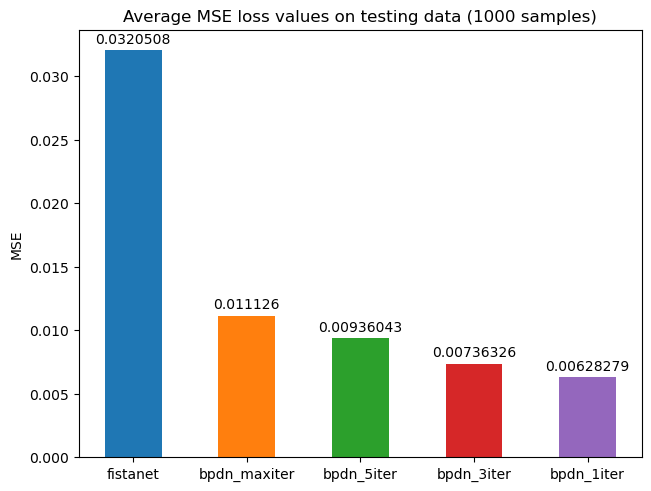

In [11]:
plot_bar_comp(losses_MSE, 'MSE', 'Average MSE loss values on testing data (1000 samples)')

## Compare single BW denoising examples

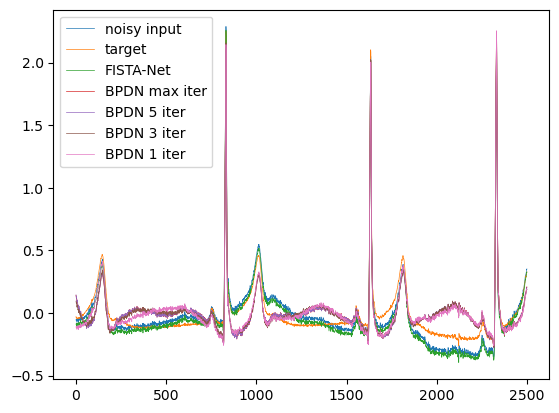

In [12]:
plot_comp_example(20)

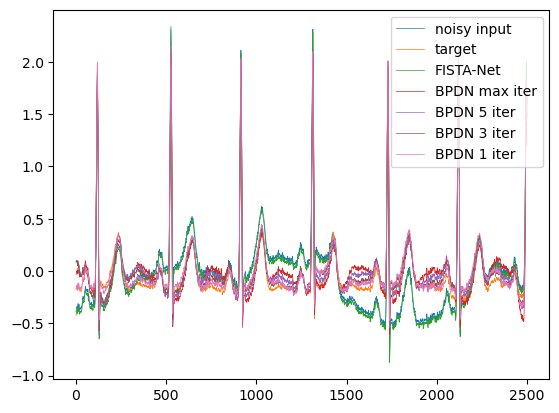

In [13]:
plot_comp_example(210)

## Compare sparcity - percentage of non-zero elements

In [14]:
non_zero_perc_func = lambda x: torch.sum(x.abs().cpu().squeeze().detach()>1e-6).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

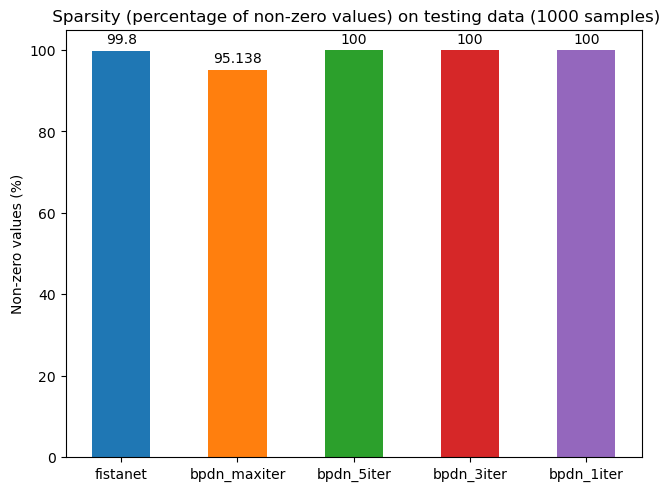

In [15]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

In [16]:
non_zero_perc_func = lambda x: torch.sum(x.abs().cpu().squeeze().detach()>1e-3).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

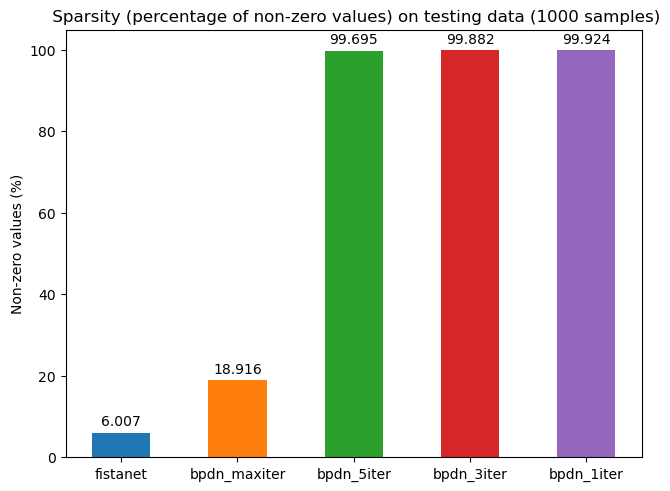

In [17]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

In [18]:
non_zero_perc_func = lambda x: torch.sum(x.abs().cpu().squeeze().detach()>1e-1).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

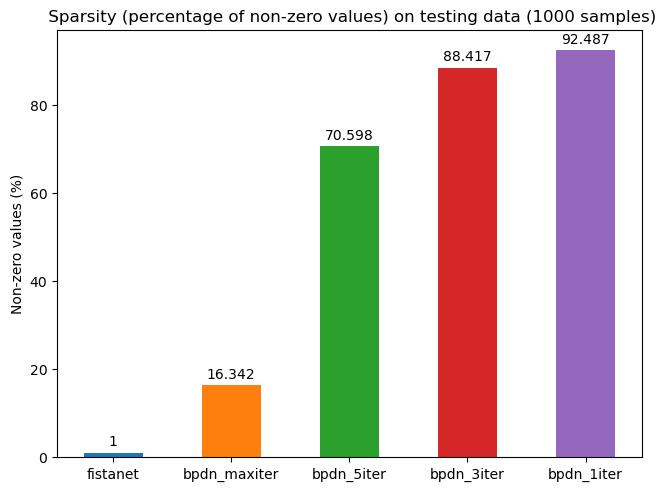

In [19]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

In [22]:
def min_max_norm(x):
    mins = x.min(dim=1).values.repeat((x.shape[1], 1)).T
    maxs = x.max(dim=1).values.repeat((x.shape[1], 1)).T
    return (x - mins) / (maxs - mins)
def max_abs_norm(x):
    mins = x.min(dim=1).values.repeat((x.shape[1], 1)).T
    maxs = x.max(dim=1).values.repeat((x.shape[1], 1)).T
    absmax = torch.stack([mins, maxs]).abs().max(dim=0).values
    return x / absmax
non_zero_perc_func = lambda x: torch.sum(x.abs().cpu().squeeze().detach()>1e-5).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc_norm = {
    'fistanet': non_zero_perc_func(max_abs_norm(x_fistanet)),
    'bpdn_maxiter': non_zero_perc_func(max_abs_norm(x_bpdn)),
    'bpdn_5iter': non_zero_perc_func(max_abs_norm(x_bpdn5)),
    'bpdn_3iter': non_zero_perc_func(max_abs_norm(x_bpdn3)),
    'bpdn_1iter': non_zero_perc_func(max_abs_norm(x_bpdn1))
}

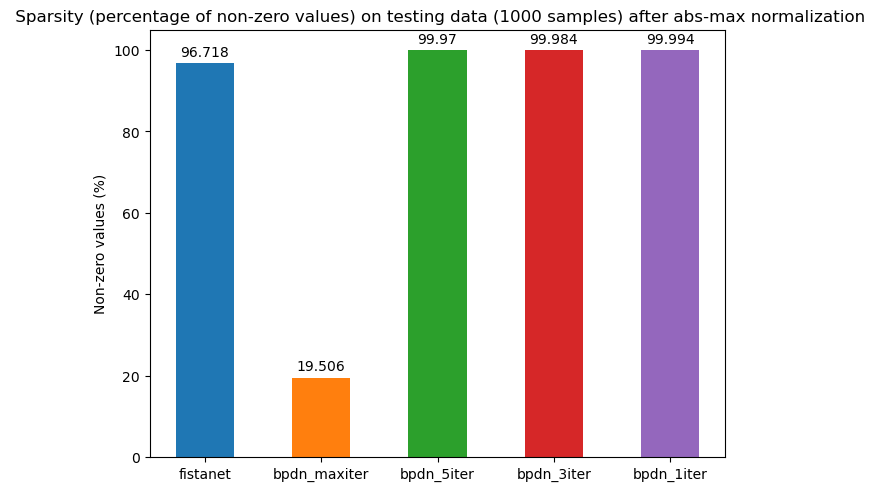

In [23]:
plot_bar_comp(non_zero_perc_norm, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples) after abs-max normalization')

In [24]:
loss = lambda x: torch.mean(torch.abs(x)).cpu()
losses_L1 = {
    'fistanet': loss(x_fistanet),
    'bpdn_maxiter': loss(x_bpdn),
    'bpdn_5iter': loss(x_bpdn5),
    'bpdn_3iter': loss(x_bpdn3),
    'bpdn_1iter': loss(x_bpdn1)
}

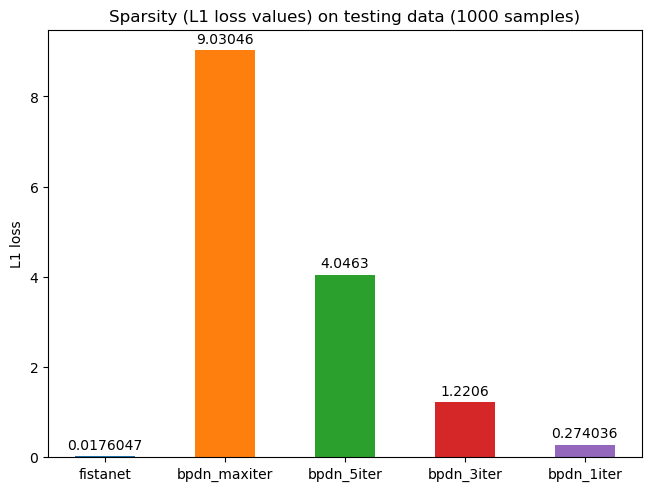

In [25]:
plot_bar_comp(losses_L1, 'L1 loss', 'Sparsity (L1 loss values) on testing data (1000 samples)')

In [26]:
loss = lambda x: torch.mean(torch.abs(x)).cpu()
losses_L1_norm = {
    'fistanet': loss(max_abs_norm(x_fistanet)),
    'bpdn_maxiter': loss(max_abs_norm(x_bpdn)),
    'bpdn_5iter': loss(max_abs_norm(x_bpdn5)),
    'bpdn_3iter': loss(max_abs_norm(x_bpdn3)),
    'bpdn_1iter': loss(max_abs_norm(x_bpdn1))
}

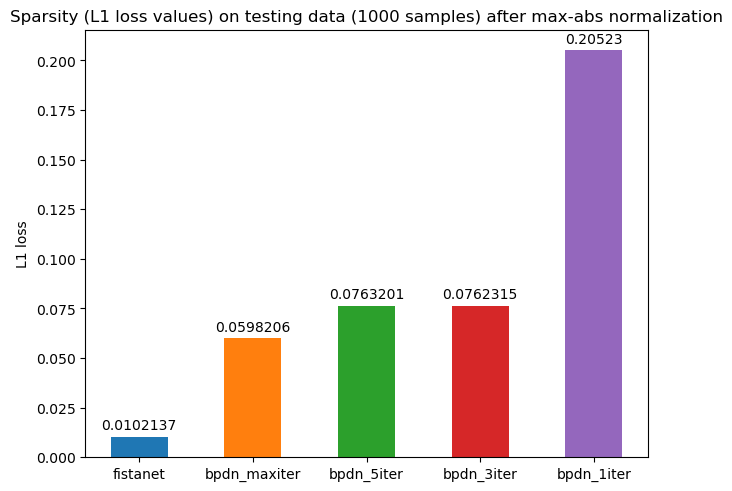

In [27]:
plot_bar_comp(losses_L1_norm, 'L1 loss', 'Sparsity (L1 loss values) on testing data (1000 samples) after max-abs normalization')

## Compare single BW noise approximation examples

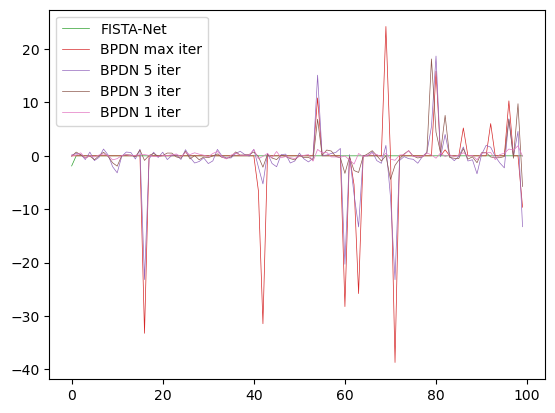

In [28]:
plot_comp_example_alpha(0)

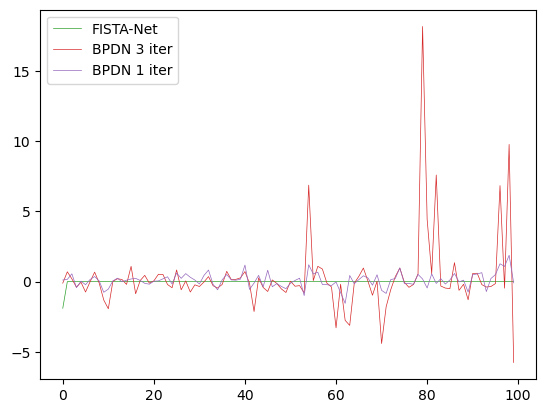

In [29]:
plot_comp_example_alpha(0, [True, False, False, True, True])

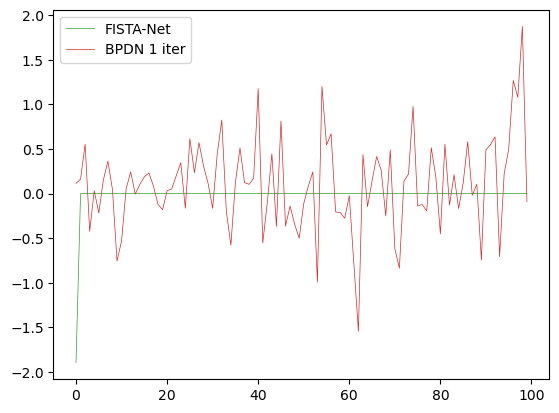

In [30]:
plot_comp_example_alpha(0, [True, False, False, False, True])

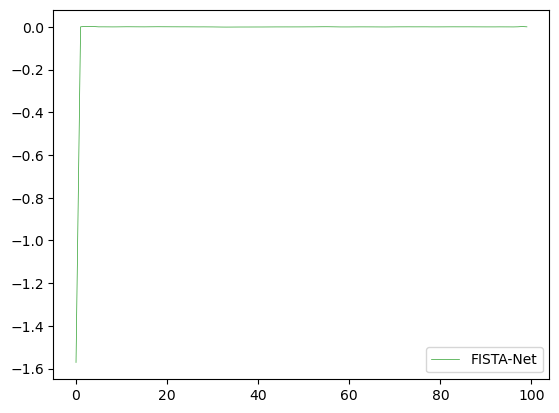

In [31]:
plot_comp_example_alpha(210, [True, False, False, False, False])

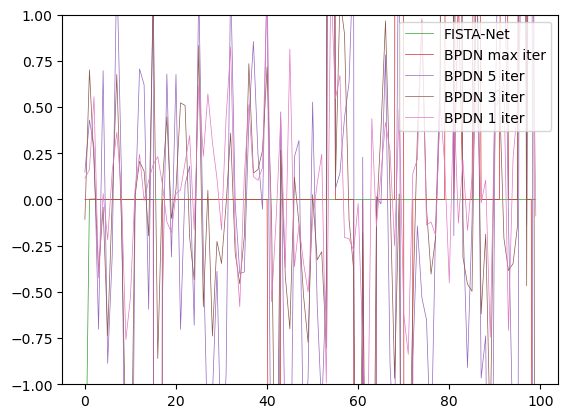

In [32]:
plot_comp_example_alpha(0, ylim=(-1, 1))

## Compare inference times

In [ ]:
print('FISTA-Net GPU (1 batch = 1000 samples):', '1.2129542999999998', 's')  # from solver.test()

FISTA-Net GPU (1 batch = 1000 samples): 1.2129542999999998 s


In [ ]:
lambda_param = 0.001
noisy = x_in[1, :].numpy()
diction = dictionary[0, :, :].numpy()

start = timeit.default_timer()

alpha = BPDN(noisy, diction, lambda_param=lambda_param)[1]

stop = timeit.default_timer()

print('BPDN CPU (1 sample):', stop - start, 's') 

BPDN CPU (1 sample): 12.018897300004028 s


In [ ]:
max_iters = 5

start = timeit.default_timer()

alpha = BPDN(noisy, diction, lambda_param=lambda_param, max_iters=max_iters)[1]

stop = timeit.default_timer()

print('BPDN CPU (1 sample):', stop - start, 's') 

BPDN CPU (1 sample): 5.832323600014206 s


In [ ]:
max_iters = 3

start = timeit.default_timer()

alpha = BPDN(noisy, diction, lambda_param=lambda_param, max_iters=max_iters)[1]

stop = timeit.default_timer()

print('BPDN CPU (1 sample):', stop - start, 's') 

BPDN CPU (1 sample): 3.877081000013277 s


In [ ]:
max_iters = 1

start = timeit.default_timer()

alpha = BPDN(noisy, diction, lambda_param=lambda_param, max_iters=max_iters)[1]

stop = timeit.default_timer()

print('BPDN CPU (1 sample):', stop - start, 's') 

BPDN CPU (1 sample): 2.0936430000001565 s


In [ ]:
runtimes = {
    'fistanet': 1.2129542999999998,
    'bpdn_maxiter': 12.018897300004028,
    'bpdn_5iter': 5.832323600014206,
    'bpdn_3iter': 3.877081000013277,
    'bpdn_1iter': 2.0936430000001565,
}

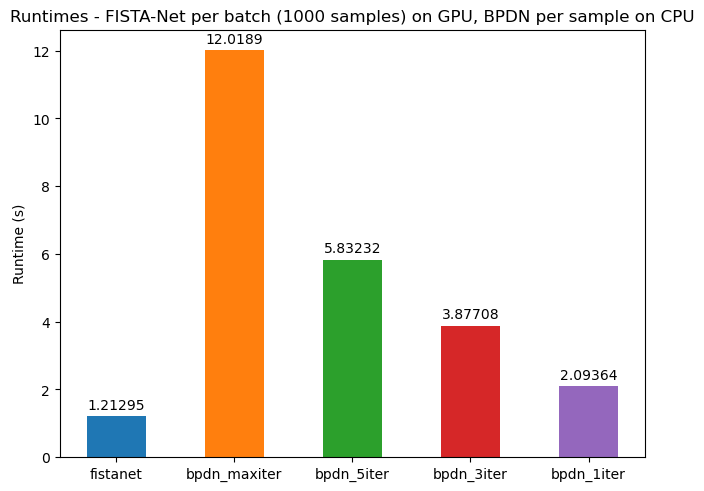

In [ ]:
plot_bar_comp(runtimes, 'Runtime (s)', 'Runtimes - FISTA-Net per batch (1000 samples) on GPU, BPDN per sample on CPU')